In [5]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import time
from datetime import datetime

In [6]:
def get_quote(ticker, start_date, end_date,interval):
    period_start  = int(time.mktime(datetime.strptime(start_date, '%m/%d/%Y %H:%M:%S').timetuple()))
    period_end    = int(time.mktime(datetime.strptime(end_date, '%m/%d/%Y %H:%M:%S').timetuple()))
    query_string =f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period_start}&period2={period_end}&interval={interval}&events=history&includeAdjustedClose=true"
    df = pd.read_csv(query_string)
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
    df = df[['Date','Close']]
    df = df.set_index(['Date'])
    return df

In [7]:
df=get_quote('AAPL', '01/01/2011 23:59:59', '09/01/2022 23:59:59','1d')

Text(0, 0.5, 'Close price USD')

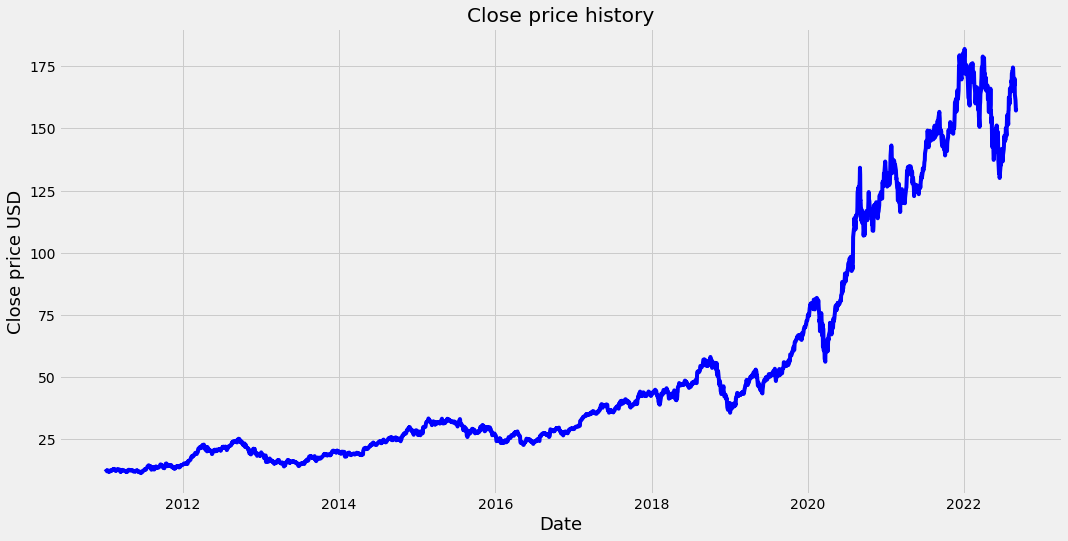

In [8]:
# Visualize the closing price history
plt.figure(figsize = (16,8))
plt.title('Close price history')
plt.plot(df['Close'], c = 'blue')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close price USD', fontsize = 18)

In [9]:
# Create a new data frame
data = df.filter(['Close'])
# Covert the dataframe to a numpy array
dataset = data.values
# Find number of rows and train the model on it
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

2350

In [10]:
#Scal the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00298057],
       [0.00334033],
       [0.00390716],
       ...,
       [0.86471341],
       [0.8548158 ],
       [0.85914969]])

In [11]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train= []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print (y_train)
        print()
        

[array([0.00298057, 0.00334033, 0.00390716, 0.00385069, 0.00435059,
       0.00567459, 0.00550517, 0.00608664, 0.00635019, 0.00693584,
       0.00529809, 0.00491951, 0.00363107, 0.00238445, 0.00462878,
       0.00545497, 0.00596742, 0.00583355, 0.0043464 , 0.00501991,
       0.00621423, 0.00606573, 0.00588166, 0.0065217 , 0.007647  ,
       0.00834142, 0.00896054, 0.00820337, 0.00868654, 0.00917389,
       0.00932448, 0.01000008, 0.00898983, 0.0073709 , 0.0048714 ,
       0.00571015, 0.00576453, 0.00686891, 0.00792519, 0.00710945,
       0.00769719, 0.00925337, 0.0093454 , 0.00837489, 0.00845855,
       0.0077704 , 0.00655726, 0.00767   , 0.00799839, 0.0062979 ,
       0.0030726 , 0.00404103, 0.00321065, 0.00501573, 0.00541313,
       0.00499272, 0.00620168, 0.00757588, 0.0073458 , 0.00745457])]
[0.006967215174152622]

[array([0.00298057, 0.00334033, 0.00390716, 0.00385069, 0.00435059,
       0.00567459, 0.00550517, 0.00608664, 0.00635019, 0.00693584,
       0.00529809, 0.00491951, 0.0

In [12]:
# Covert training data and label to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
# reshape the data because LSTM model expecting 3 dimenssion 
#1. number of samples 2.Number of timestamps 3. number of features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] ,1))
x_train.shape

(2290, 60, 1)

In [184]:
# Build the LSTM model
model = Sequential()
# LSTM layer 50 neruns and return sequence is true because we are going to add one more layer of LSTM 
model.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1],1)))
# Second layer LSTM
model.add(LSTM(50, return_sequences = False))

model.add(Dense(25))
model.add(Dense(1))

In [185]:
#compile model with optimizer to improve upon the lost function and lost function for measuring how the model did on training
model.compile(optimizer='adam',loss='mean_squared_error')
# batch_size the total number of traing example in each batch. 
# epochs = total number of number of itirations that the dataset pass forward and backward through a nural network 
model.fit(x_train, y_train, batch_size = 1, epochs =1)

2290/2290 [==============================] - 143s 60ms/step - loss: 2.5008e-04


In [186]:
# Create testing dataset
# Create new dataset containing scaled values 
test_data = scaled_data[training_data_len - 60:,:]
# Create the dataset x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


In [187]:
# Convert the data to numpy array
x_test = np.array(x_test)

In [188]:
# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))


In [189]:
# Get model pridicted price values
predictions = model.predict(x_test)
# We are going inverse stanardization to have the same values in the y_test
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 2s 33ms/step


In [190]:
# evaluate model get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.281198319152104

C:\Users\ma\AppData\Local\Temp\ipykernel_7800\1646421461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


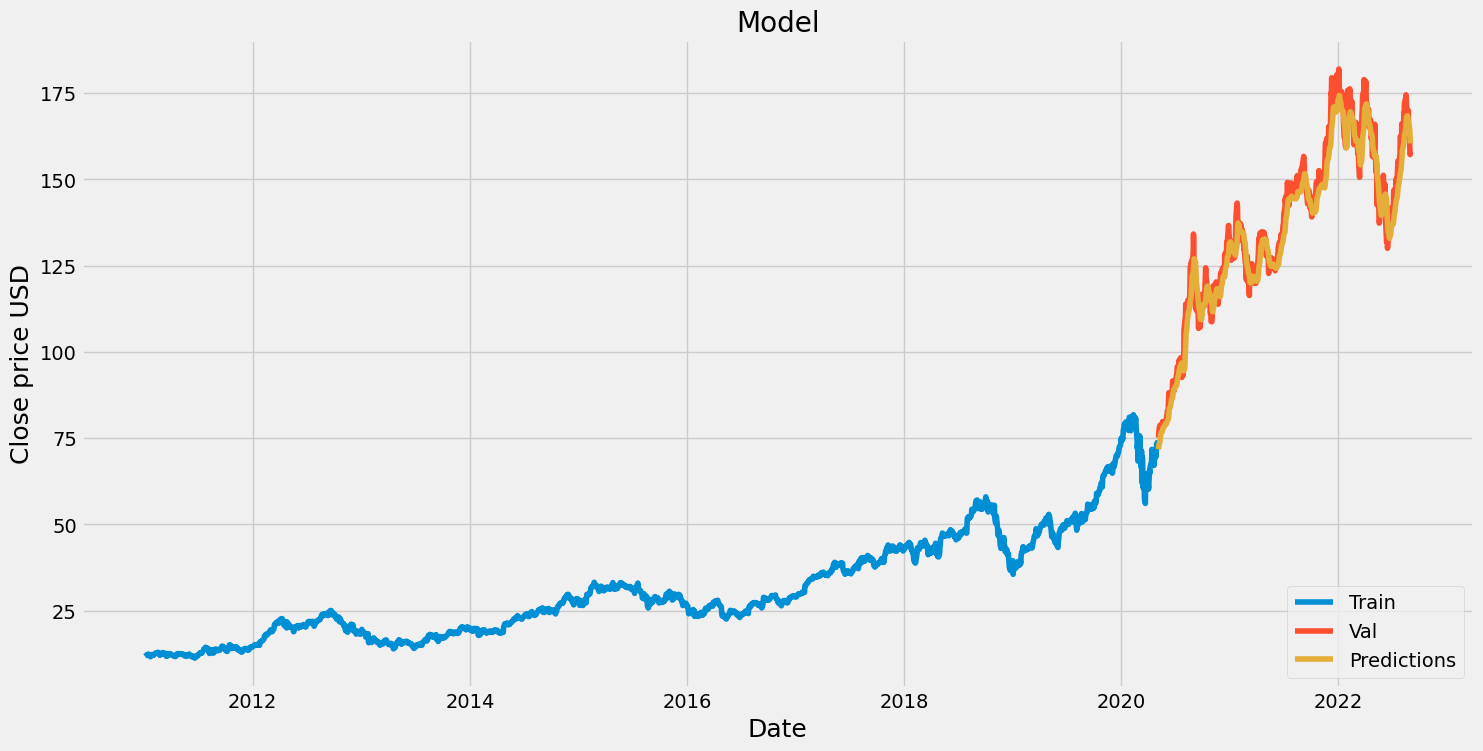

In [191]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# visualize the data
plt.figure(figsize = (16,8))
plt.title("Model")
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close price USD', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'] , loc = 'lower right')
plt.show()

In [192]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2020-05-06,75.157501,71.820885
2020-05-07,75.934998,72.469910
2020-05-08,77.532501,73.167244
2020-05-11,78.752502,73.994553
2020-05-12,77.852501,74.932510
...,...,...
2022-08-26,163.619995,166.199432
2022-08-29,161.380005,165.218323
2022-08-30,158.910004,163.871933


In [193]:
# Predict
# Get the quote
apple_quote = get_quote('AAPL', '09/01/2022 23:59:59', '11/03/2022 23:59:59','1d')
# Create new dataframe 
apple_quote = apple_quote.filter(['Close'])
#Get teh last 60 day closing price values and convert the dataframe to an array
last_60_days = apple_quote[-60:]. values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
x_test = []
# Append the past 60 days
x_test.append(last_60_days_scaled)
# convert the x_test to a numpy array
x_test = np.array(x_test)
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
#  Get the predicted sacle price
pred_price = model.predict(x_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(f"predicted price for 11/03/2022 : {pred_price}")

1/1 [==============================] - 2s 2s/step
predicted price for November 4th : [[146.60622]]


In [194]:
apple_quote2 = get_quote('AAPL', '11/03/2022 23:59:59', '11/04/2022 23:59:59','1d')
print(apple_quote2)

                 Close
Date                  
2022-11-04  138.380005


In [195]:
type(pred_price)

numpy.ndarray